# Criação de modelo de machine learning para encontrar possíveis clientes
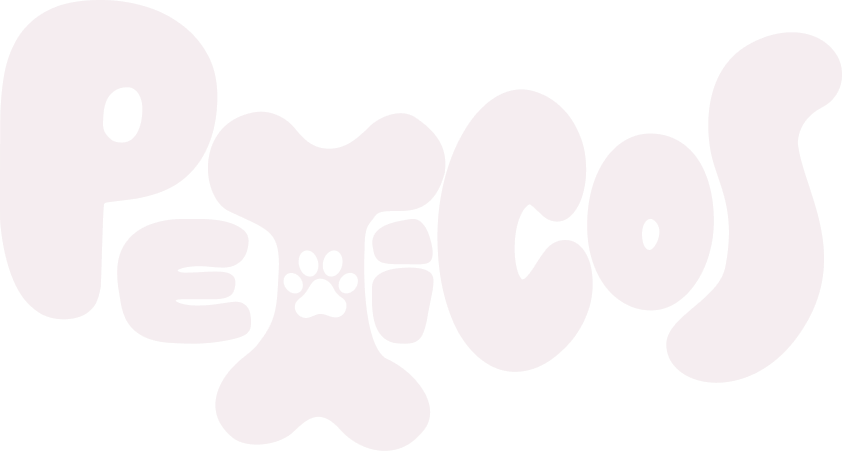

# Importação

## Leitura

In [60]:
# o pandas é usado para ler e manipular os dados das nossas bases (os arquivos)
import pandas as pd

# o train_test_split é usado para separar a base de treino e a base de teste
# o GridSearchCV é usado para escolher os melhores parâmetros para o modelo
from sklearn.model_selection import train_test_split, GridSearchCV

## Modelo
Aqui são importadas as classes dos modelos que serão testados

In [61]:
# árvore de decisão
from sklearn.tree import DecisionTreeClassifier

# naive baeys
from sklearn.naive_bayes import GaussianNB

# KNN
from sklearn.neighbors import KNeighborsClassifier

# serialização
import pickle as pkl

### Avaliação do modelo

In [62]:
# reporte de classificação
# matriz de confusão
from sklearn.metrics import classification_report, confusion_matrix

# Treinamento do modelo

## Leitura do DataFrame

In [63]:
# Lendo e juntando os dois arquivos
df = pd.concat([pd.read_csv('FORMS 2/base_tratada_forms_2.csv').loc[:, 'age':], pd.read_csv('FORMS 1/treated_df.csv').loc[:, 'age':]]).drop(columns=['is_lgbt']).dropna()
df.to_csv('bases_juntas.csv')
df

,age,gender,time_in_social_media,people_living_together,social_class,has_pets,number_of_pets,has_dog,has_cat,has_others,forgets,report_abandoned,feeling,would_use
0,17,1,3.0,3,2,0,0.0,0,0,0,1,4,3.0,1.0
1,47,1,2.0,3,2,0,0.0,0,0,0,1,4,3.0,1.0
2,17,1,2.0,4,2,1,2.0,1,0,1,1,4,5.0,1.0
3,16,0,2.0,3,4,1,1.0,1,0,0,1,4,3.0,0.0
4,11,2,5.0,4,2,1,1.0,1,0,0,1,2,5.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,40,1,2.0,4,3,1,2.0,0,0,0,0,4,3.0,0.0
350,50,1,2.0,2,3,1,1.0,1,0,0,0,3,3.0,1.0
351,40,1,2.0,3,3,1,1.0,1,0,0,1,4,3.0,1.0
352,50,0,0.0,2,3,0,0.0,0,0,0,1,2,3.0,1.0


#### Tratamento de colunas

##### Reportar abandonado estava de 0 a 4, dividindo tudo por 4 deixa o parâmetro de 0 a 1

In [64]:
df['report_abandoned'] = df['report_abandoned']/4

##### Quem respondeu que talvez usaria também é um potencial usuário

In [65]:
df.loc[df['would_use'] == 0.5, 'would_use'] = 1

#### Balanceamento

In [66]:
df.groupby('would_use').size()

would_use
0.0    128
1.0    447
dtype: int64

In [67]:
from imblearn.over_sampling import SMOTE

X = df.drop('would_use', axis=1)
y = df['would_use']

smote = SMOTE(sampling_strategy='auto', random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

df = pd.DataFrame(X_resampled, columns=X.columns)
df['would_use'] = y_resampled

df.groupby('would_use').size()

would_use
0.0    447
1.0    447
dtype: int64

## Divisão do DataFrame

### Separação features e resposta

In [68]:
x = df.drop(columns=['would_use'])
y = df['would_use']

### Separação treino e teste

In [69]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

## Treinamento

### Model Training pipeline

In [70]:
def model_training(model_name: str, x_train: pd.DataFrame, y_train, params: dict = None):
    '''
    # Pipeline de treino para o modelo
    Essa função já faz o treino automático do modelo, recebendo como parâmetros o nome do modelo, os parâmetros 
    # Parâmetros:
     - model_name - modelo que será usado [naive_baeys, decision_tree (árvore de decisão), knn]
     - x_train - DataFrame do pandas, com todas as features e os valores da base
     - y_train - Lista com as respostas de cada linha do x_train, na mesma ordem
     - params - dicionário com parâmetro:valor a ser usado no modelo, caso seja None, vai escolher os melhores parâmetros
    '''
    
    # Dicionário com os possíveis parâmetros para cada modelo (knn & tree)
    param_grid = {
        'decision_tree': { 'max_depth': [3, 5, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': [None, 'sqrt', 'log2'], 'criterion': ['gini', 'entropy'] }, 
        'knn': { 'n_neighbors': range(2, (len(y_train)//2)+1), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan', 'minkowski']}
    }

    # Dicionário com os nomes dos modelos e suas classes
    models = {'naive_baeys':GaussianNB, 'decision_tree':DecisionTreeClassifier, 'knn': KNeighborsClassifier}

    # Definindo o modelo escolhido
    if model_name != 'naive_baeys':
        if params == None:
            model = models[model_name]()
            gs = GridSearchCV(estimator=model, param_grid=param_grid[model_name], scoring='accuracy', n_jobs=-1, cv=5)
            gs.fit(x_train, y_train)
            model = models[model_name](**gs.best_params_)
        else:
            model = models[model_name](**params)
    else:
        model = models[model_name]()
    
    model.fit(x_train, y_train)
    
    return model

### Model Testing Pipeline

In [71]:
def test(model, x_test, y_test):
    y_pred = model.predict(x_test)
    print(classification_report(y_pred=y_pred, y_true=y_test))
    return y_pred

### Naive Baeys

#### Treinando o modelo

In [72]:
naive_model = model_training('naive_baeys', x_train, y_train)

#### Testando o modelo

##### Base de teste

In [73]:
y_pred = test(naive_model, x_test, y_test)

              precision    recall  f1-score   support

         0.0       0.63      0.77      0.69       100
         1.0       0.77      0.64      0.70       124

    accuracy                           0.70       224
   macro avg       0.70      0.70      0.70       224
weighted avg       0.71      0.70      0.70       224



##### Base de treino

In [74]:
train_pred = test(naive_model, x_train, y_train)

              precision    recall  f1-score   support

         0.0       0.69      0.84      0.76       347
         1.0       0.77      0.59      0.67       323

    accuracy                           0.72       670
   macro avg       0.73      0.71      0.71       670
weighted avg       0.73      0.72      0.71       670



### Decision Tree

#### Treinando o modelo

Os parâmetros foram mudados, pois, com os melhores parâmetros do gridsearch, estava ocorrendo overfitting

In [75]:
tree_model = model_training('decision_tree', x_train, y_train)

#### Testando o modelo

##### Base de teste

In [76]:
y_pred = test(tree_model, x_test, y_test)

              precision    recall  f1-score   support

         0.0       0.81      0.80      0.80       100
         1.0       0.84      0.85      0.84       124

    accuracy                           0.83       224
   macro avg       0.82      0.82      0.82       224
weighted avg       0.83      0.83      0.83       224



##### Base de treino

In [77]:
train_pred = test(tree_model, x_train, y_train)

              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90       347
         1.0       0.88      0.91      0.89       323

    accuracy                           0.90       670
   macro avg       0.90      0.90      0.90       670
weighted avg       0.90      0.90      0.90       670



### KNN

#### Treinando o modelo

In [78]:
knn_model = model_training('knn', x_train, y_train)

#### Testando o modelo

##### Base de teste

In [79]:
y_pred = test(knn_model, x_test, y_test)

              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85       100
         1.0       0.93      0.80      0.86       124

    accuracy                           0.85       224
   macro avg       0.86      0.86      0.85       224
weighted avg       0.86      0.85      0.85       224



##### Base de treino

In [80]:
train_pred = test(knn_model, x_train, y_train)

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       347
         1.0       1.00      0.99      1.00       323

    accuracy                           1.00       670
   macro avg       1.00      1.00      1.00       670
weighted avg       1.00      1.00      1.00       670



# Serialização

Mesmo que o modelo KNN tenha uma acurácia maior, no da árvore de decisão os outros parâmetros são mais balanceados, o que indica uma performace geral melhor do modelo. Então, o modelo usado será o da árvore.

In [81]:
with open('model_user.pkl ', 'wb') as f:
    pkl.dump(tree_model, f)

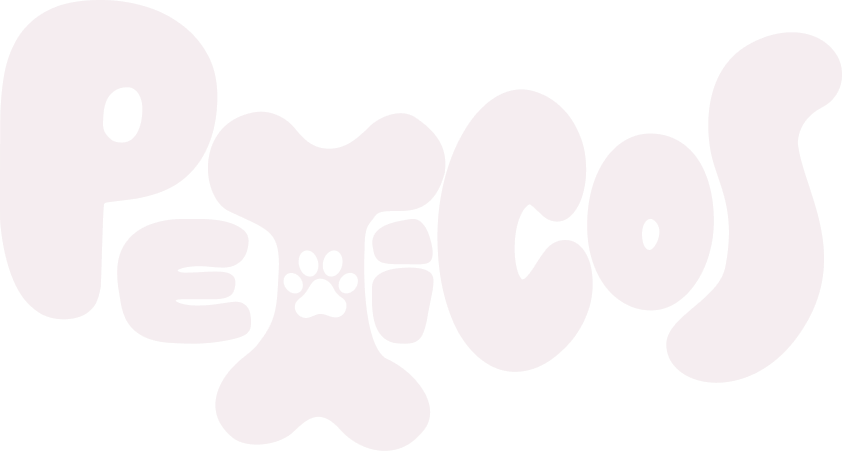